**Objectives**

Create and analyze a statistical machine learning model that provides explanatory information about the FPED components for two different classes: seafood meals and non-seafood meals. A logistic regression model is chosen due to its ability to provide such explanatory information of multiple variables among two different groups. The logistic regression model is set up such that the FPED components are used as the predictive variables to classify, or predict, whether a meal contains seafood or not. 

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from itertools import combinations
import numpy as np
import scipy.stats as stat
import sys
import time 

def nhanes_full_log_reg(df, fped_vars, var_combinatorial, batch_run, batch_num, 
                        batch_step, non_sfd_class_n, sfd_class_n, test_ratio):
    
    #Model execution start time
    startTime = time.time()
    #Create list of all FPED variable combinations if desired    
    if (var_combinatorial == True):
        cmb_output = sum([list(map(list, combinations(fped_vars , i))) for i in range(len(fped_vars ) + 1)], [])
        cmb_output = cmb_output[1:]
    else: 
        cmb_output = fped_vars

    #Partition the list of FPED variable combinations with batch parameters, if batch run desired
    if (batch_run == True):
        #Obtain batch length and step through the indecies of the variable list
        batch_len = int(len(cmb_output)/batch_num)
        idx1 = 0 + batch_len*int(batch_step)
        idx2 = batch_len + batch_len*int(batch_step)
        cmb_output = cmb_output[idx1:idx2]

    #This is the model fitting loop if combinatorial variable model selection is desired
    if (var_combinatorial == True):
        #Lists for storing the model prediction success rate and variable list
        pred_sr = []
        var_list = []
        #Loops through the generate variable combinations
        for var in cmb_output:
            #Sample the seafood and non-seafood classes, create model input df
            df_non_sfd = df[df['seafood_meal']==0].sample(n=non_sfd_class_n)
            df_sfd = df[df['seafood_meal']==1].sample(n=sfd_class_n)
            df_mdl = pd.concat([df_non_sfd, df_sfd])
            #Add the classification target variable to the df input list
            var.append('seafood_meal')
            #Use variable combination selected by loop
            df_mdl = df_mdl[var]
            #Split the training and test data
            X_train, X_test, y_train, y_test = train_test_split(df_mdl.drop(['seafood_meal'], axis=1), df_mdl['seafood_meal'], test_size=test_ratio)
            #Fit the logistic regression model
            log_reg = LogisticRegression()
            log_reg.fit(X_train, y_train)
            #Obtain predictions on test set and calculate success rate
            y_pred = log_reg.predict(X_test)
            n_correct = sum(y_pred == y_test)
            sr = n_correct/len(y_pred)
            #Add success rate and variables used to list for storing outside loop
            pred_sr.append(sr)
            var.remove('seafood_meal')
            var_list.append(var)
            var_idx = cmb_output.index(var)
            progress_pct = round(100 * var_idx / len(cmb_output), 2)
            #if (progress_pct%1==0):
                #print("Progress: "+str(progress_pct)+" %")
        
        #Calculate model execution time for combinatorial variable selection    
        cmb_time = time.time() - startTime  
        cmb_time_list = [cmb_time] * len(cmb_output)
        cmb_time_df = pd.DataFrame(cmb_time_list)
        cmb_time_df = cmb_time_df.rename({0: 'Runtime(Seconds)'}, axis=1)
        #Create a dataframe with variables used, their success rate , and runtime   
        pred_sr_df = pd.DataFrame(pred_sr)
        pred_sr_df = pred_sr_df.rename({0: 'Success Rate'}, axis=1)
        var_list_df = pd.DataFrame(var_list)
        model_result = pd.concat([var_list_df, pred_sr_df, cmb_time_df], axis=1)
        
        
        
    #Condition if variable combination is not desired  
    else:
        #Sample the seafood and non-seafood classes, create model input df
        df_non_sfd = df[df['seafood_meal']==0].sample(n=non_sfd_class_n)
        df_sfd = df[df['seafood_meal']==1].sample(n=sfd_class_n)
        df_mdl = pd.concat([df_non_sfd, df_sfd])
        #Add the classification target variable to the df input list
        fped_vars.append('seafood_meal')
        #Use variable combination selected by loop
        df_mdl = df_mdl[fped_vars]
        #Split the training and test data
        X_train, X_test, y_train, y_test = train_test_split(df_mdl.drop(['seafood_meal'], axis=1), df_mdl['seafood_meal'], test_size=test_ratio)
        #Fit the logistic regression model
        log_reg = LogisticRegression()
        log_reg.fit(X_train, y_train)
        #Obtain predictions on test set and calculate success rate
        y_pred = log_reg.predict(X_test)
        n_correct = sum(y_pred == y_test)
        pred_sr = [str(n_correct/len(y_pred))]
        #Calculate model execution time for combinatorial variable selection    
        non_cmb_time = time.time() - startTime  
        non_cmb_time_df = pd.DataFrame([non_cmb_time ])
        non_cmb_time_df = non_cmb_time_df.rename({0: 'Runtime(Seconds)'}, axis=1)
        #Create a dataframe with variables used and their success rate    
        pred_sr_df = pd.DataFrame(pred_sr)
        pred_sr_df = pred_sr_df.rename({0: 'Success Rate'}, axis=1)
        fped_vars.remove('seafood_meal')
        var_list_df = pd.DataFrame([fped_vars])
        model_result = pd.concat([var_list_df, pred_sr_df, non_cmb_time_df], axis=1)
    
    #Returns result from model.     
    return model_result
 

**Model Selection**

A model that provides an acceptable prediction accuracy rate is necessary to provide some confidence in the explanation power of the input data. As such, the objective is to find a model with an acceptable prediction accuracy, and use the selected features to provide some inferences about seafood vs non-seafood consumption in a typical meal. 

Since the model is more geared towards providing explainability of the FPED components, the typical regression model selection strategies of forward or backward stepwise for feature selection are not very useful in this case. This is because these methods will likely select feature based on the input order provided, potentially eliminating features that are otherwise beneficial for explainability. Therefore, a model evaluation method that evaluates as many combinations of features as possible is necessary to meet this objective. 

**Model Features**

There are a total of 38 variables that make up the FPED components. This presents a challenge for building a solid logistic regression solution for this type of classification, due to the high dimensionality of the data. As such, it is important to find an acceptable balance between the number of features and the prediction accuracy of the model. The high number of features also presents a challenge for any combinatorial task that is used for model selection. With 38 features, there are a total of 2^38 = 2.75e^8 possible feature combinations. So the starting point for feature selection has to be reduced to a smaller number in order to address the computing requirements, which will require a strategic approach. The feature set starting point has been broken down into multiple levels as follows.

In [3]:
#Create a list of the high level food components, as defined in the FPED
#Fruit, Vegetables, Grains, Protein Foods, and Dairy components
#Include oils, fats, and sugars at this level.
food_cmp_level1 = ['F_TOTAL','V_TOTAL','G_TOTAL','D_TOTAL','OILS', 
                   'SOLID_FATS', 'ADD_SUGARS']

#Level 2 contains the subcomponents of vegetables, grains, and dairy 
#Keep fruits at total level
#Include oils, fats, and sugars at this level.
food_cmp_level2 = ['F_TOTAL', 
                   'V_DRKGR', 'V_REDOR_TOMATO','V_REDOR_OTHER', 'V_STARCHY_POTATO', 
                   'V_STARCHY_OTHER', 'V_OTHER', 'V_LEGUMES', 
                   'G_WHOLE','G_REFINED', 
                   'D_MILK', 'D_YOGURT','D_CHEESE', 
                   'OILS', 'SOLID_FATS', 'ADD_SUGARS'] 

#Level 3 has all components from level2, 
#adding a generated total protein component other than meat and seafood
food_cmp_level3 = ['F_TOTAL', 
                   'V_DRKGR', 'V_REDOR_TOMATO','V_REDOR_OTHER', 'V_STARCHY_POTATO', 
                   'V_STARCHY_OTHER', 'V_OTHER', 'V_LEGUMES', 
                   'G_WHOLE','G_REFINED', 
                   'PF_PLANT_D_TOTAL', 
                   'D_MILK', 'D_YOGURT','D_CHEESE', 
                   'OILS', 'SOLID_FATS', 'ADD_SUGARS'] 

#Level 4 has all components from level3, 
#breaking down the total protein component
food_cmp_level4 = ['F_TOTAL', 
                   'V_DRKGR', 'V_REDOR_TOMATO','V_REDOR_OTHER', 'V_STARCHY_POTATO', 
                   'V_STARCHY_OTHER', 'V_OTHER', 'V_LEGUMES', 
                   'G_WHOLE','G_REFINED', 
                   'PF_EGGS', 'PF_SOY', 'PF_NUTSDS', 'PF_LEGUMES', 
                   'D_MILK', 'D_YOGURT','D_CHEESE', 
                   'OILS', 'SOLID_FATS', 'ADD_SUGARS'] 

#Level 5 has all components of level4, but breaks the total fruit into subcomponents
food_cmp_level5 = ['F_CITMLB', 'F_OTHER', 'F_JUICE', 
                   'V_DRKGR', 'V_REDOR_TOMATO', 'V_REDOR_OTHER', 'V_STARCHY_POTATO', 
                   'V_STARCHY_OTHER', 'V_OTHER', 'V_LEGUMES', 
                   'G_WHOLE','G_REFINED', 
                   'PF_EGGS', 'PF_SOY', 'PF_NUTSDS', 'PF_LEGUMES', 
                   'D_MILK', 'D_YOGURT', 'D_CHEESE', 
                   'OILS', 'SOLID_FATS', 'ADD_SUGARS']  

food_cmp_level1_len = len(food_cmp_level1)
food_cmp_level2_len = len(food_cmp_level2)
food_cmp_level3_len = len(food_cmp_level3)
food_cmp_level4_len = len(food_cmp_level4)
food_cmp_level5_len = len(food_cmp_level5)
food_cmp_level1_cmb = 2**food_cmp_level1_len
food_cmp_level2_cmb = 2**food_cmp_level2_len
food_cmp_level3_cmb = 2**food_cmp_level3_len
food_cmp_level4_cmb = 2**food_cmp_level4_len
food_cmp_level5_cmb = 2**food_cmp_level5_len

print("Number of features in L1: "+str(food_cmp_level1_len)+" = "+str(food_cmp_level1_cmb)+" possible combinations")
print("Number of features in L2: "+str(food_cmp_level2_len)+" = "+str(food_cmp_level2_cmb)+" possible combinations")
print("Number of features in L3: "+str(food_cmp_level3_len)+" = "+str(food_cmp_level3_cmb)+" possible combinations")
print("Number of features in L4: "+str(food_cmp_level4_len)+" = "+str(food_cmp_level4_cmb)+" possible combinations")
print("Number of features in L5: "+str(food_cmp_level5_len)+" = "+str(food_cmp_level5_cmb)+" possible combinations")

Number of features in L1: 7 = 128 possible combinations
Number of features in L2: 16 = 65536 possible combinations
Number of features in L3: 17 = 131072 possible combinations
Number of features in L4: 20 = 1048576 possible combinations
Number of features in L5: 22 = 4194304 possible combinations


**Data Observations**

This section explores the charactestics of the data observations, with the aim of identifying potential issues regarding the model fitting.

In [4]:
#Read the pre-processed dataframe, add total plant protein component included in level 3
df = pd.read_csv('../../Data/nhanes_full_pre_proc.csv')
df['PF_PLANT_D_TOTAL'] = df['PF_EGGS']+df['PF_SOY']+df['PF_NUTSDS']+df['PF_LEGUMES']

#Obtain number of total observations
n_obs_total = len(df)
#Obtain number of observations in each class with ratios
n_obs_sfd_class = len(df[df['seafood_meal']==1])
n_obs_sfd_pct = round(100 * n_obs_sfd_class / n_obs_total, 2)
n_obs_non_sfd_class = len(df[df['seafood_meal']==0])
n_obs_non_sfd_pct = round(100 * n_obs_non_sfd_class / n_obs_total, 2)

print("The data frame contains a total of "+str(n_obs_total)+" observations.")
print("The data frame contains a total of "+str(n_obs_sfd_class)+" meals that contain seafood.")
print("The data frame contains a total of "+str(n_obs_non_sfd_class)+" meals that do not contain seafood.")
print("The seafood class makes up "+str(n_obs_sfd_pct)+"% of observations.")
print("The seafood class makes up "+str(n_obs_non_sfd_pct)+"% of observations.")

The data frame contains a total of 102712 observations.
The data frame contains a total of 5949 meals that contain seafood.
The data frame contains a total of 96763 meals that do not contain seafood.
The seafood class makes up 5.79% of observations.
The seafood class makes up 94.21% of observations.


This dataframe contains a high number of observations, and the classes are imbalanced. In order to address these issues, the same number of observations from each class will be sampled. N = 1000 seems like a reasonable starting point for each class, making N = 2000 for the model input. 

**Computational Constraints**

A few exploratory runs of the model have been executed using the High Performance Computing (HPC) cluster at American University. Using N = 2000, the following runtimes were observed:

Number of FPED features = 14, runtime = 1538 seconds = 25.6 minutes.

Number of FPED features = 15, runtime = 2095 seconds = 34.9 minutes.

Number of FPED features = 16, runtime = 4433 seconds = 73.4 minutes.

Number of FPED features = 17, runtime = 9012 seconds = 150.2 minutes.


The HPC runtime seems to follow the expontential growth trend for each added variable. So this can be used to predict runtime if a variable is added or removed from the combinatorial set. With this logic, a maximum number of features for an HPC task seems in the realm of 18-20 variables. Anything beyond this number will require a batch setup to make use of the parallel computing capability of the HPC. The logistic model function has included provisions for using batching in case this is required. 

**Model Fitting**

Use all combinations from the level 1 features to fit a model, and obtain the prediction success rate on each run, using a 80% to 20% train/test split. 

In [5]:
model_res_df = nhanes_full_log_reg(df = df,
                                       fped_vars = food_cmp_level1, 
                                        var_combinatorial = True, 
                                        batch_run = False, 
                                        batch_num = 2, 
                                        batch_step = 1, 
                                        non_sfd_class_n = 1000, 
                                        sfd_class_n = 1000, 
                                        test_ratio = 0.2)

top_success_rate = model_res_df.sort_values(by="Success Rate", ascending=False).head(10)
print(top_success_rate)

           0        1        2           3           4     5     6  \
117  V_TOTAL  D_TOTAL     OILS  SOLID_FATS  ADD_SUGARS  None  None   
113  V_TOTAL  G_TOTAL  D_TOTAL        OILS  SOLID_FATS  None  None   
98   F_TOTAL  V_TOTAL  G_TOTAL     D_TOTAL        OILS  None  None   
105  F_TOTAL  V_TOTAL  D_TOTAL        OILS  ADD_SUGARS  None  None   
69   F_TOTAL  V_TOTAL  D_TOTAL  ADD_SUGARS        None  None  None   
76   F_TOTAL  G_TOTAL     OILS  SOLID_FATS        None  None  None   
22   D_TOTAL     OILS     None        None        None  None  None   
67   F_TOTAL  V_TOTAL  D_TOTAL        OILS        None  None  None   
80   F_TOTAL  D_TOTAL     OILS  ADD_SUGARS        None  None  None   
73   F_TOTAL  G_TOTAL  D_TOTAL        OILS        None  None  None   

     Success Rate  Runtime(Seconds)  
117        0.7200          4.014516  
113        0.7100          4.014516  
98         0.6950          4.014516  
105        0.6850          4.014516  
69         0.6825          4.014516  
7

The table above is displaying the top ten results, based on success rate, from the combinations of features that were fit to the model. 

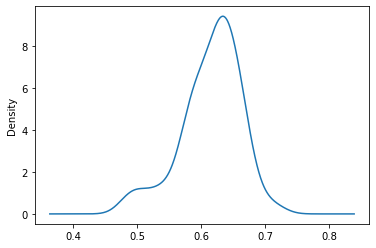

In [6]:
model_res_df['Success Rate'].plot.kde()

The plot above is showing the density of the success rate results, with the center just above the 0.6 prediction success rate. 

**Additional Runs**

Insert results for L2 and L3 runs here.

/Users/jori/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (9,10,11,12,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/jori/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/jori/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


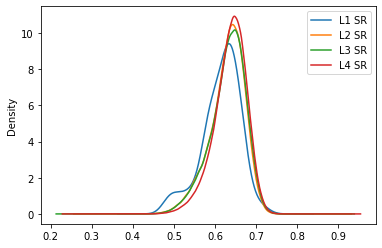

In [10]:
model_res_df_L2 = pd.read_csv('../../Model_Results/model_res_df_L2.csv')
model_res_df_L3 = pd.read_csv('../../Model_Results/model_res_df_L3.csv')
model_res_df_L4 = pd.read_csv('../../Model_Results/model_res_df_L4.csv')

model_res_df['L1 SR'] = model_res_df['Success Rate']
model_res_df['L1 SR'].plot.kde(legend="L1")
model_res_df = model_res_df.drop(['L1 SR'], axis = 1)
model_res_df_L2['L2 SR'] = model_res_df_L2['Success Rate']
model_res_df_L2['L2 SR'].plot.kde(legend="L2")
model_res_df_L2 = model_res_df_L2.drop(['L2 SR'], axis = 1)
model_res_df_L3['L3 SR'] = model_res_df_L3['Success Rate']
model_res_df_L3['L3 SR'].plot.kde(legend="L3")
model_res_df_L3 = model_res_df_L3.drop(['L3 SR'], axis = 1)
model_res_df_L4['L4 SR'] = model_res_df_L4['Success Rate']
model_res_df_L4['L4 SR'].plot.kde(legend="L4")
#model_res_df_L2['Success Rate'].plot.kde()
#model_res_df_L3['Success Rate'].plot.kde()
#model_res_df_L4['Success Rate'].plot.kde()

/Users/jori/anaconda2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jori/anaconda2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/Users/jori/anaconda2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jori/anaconda2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/Users/jori/anaconda2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jori/anaconda2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/Users/jori/anaconda2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jori/anaconda2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/Users/jori/anaconda2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jori/anaconda2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

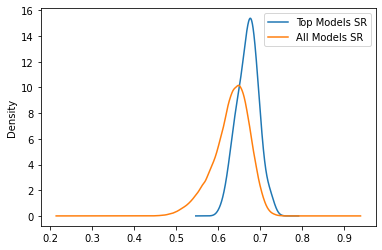

In [11]:
df = pd.read_csv('../../Data/nhanes_full_pre_proc.csv')
df['PF_PLANT_D_TOTAL'] = df['PF_EGGS']+df['PF_SOY']+df['PF_NUTSDS']+df['PF_LEGUMES']

def model_sel(df_sel, var_level, top_n_sel):
    top_n_sel = var_level.sort_values(by = 'Success Rate', ascending=False).head(top_n_sel)
    top_n_sel_vars = top_n_sel.drop(['Success Rate', 'Runtime(Seconds)'], axis=1)
    top_n_sel_vars = top_n_sel_vars.reset_index()
    result = pd.DataFrame([])
    for index, row in top_n_sel_vars.iterrows():
        model_sel_var_list = top_n_sel_vars.loc[index].to_list()
        model_sel_var_list = model_sel_var_list[2:]
        model_sel_var_list_final = []
        for x in model_sel_var_list: 
            if str(x) != 'nan': model_sel_var_list_final.append(x)
        d = nhanes_full_log_reg(df_sel,
                                fped_vars = model_sel_var_list_final, 
                                var_combinatorial = False, 
                                batch_run = False, 
                                batch_num = 2, 
                                batch_step = 1, 
                                non_sfd_class_n = 1000, 
                                sfd_class_n = 1000, 
                                test_ratio = 0.2)
        result = result.append(d)
        
    result['Success Rate'] = result['Success Rate'].astype(float)
    return result

#Run model selection for the L3 results, select top 100
model_sel = model_sel(df, model_res_df_L3, 100)


#Plot and compare to all variable input combinations
model_sel['Top Models SR'] = model_sel['Success Rate']
model_sel['Top Models SR'].plot.kde(legend="L4")
model_res_df_L3['All Models SR'] = model_res_df_L3['Success Rate']
model_res_df_L3['All Models SR'].plot.kde(legend="L3")

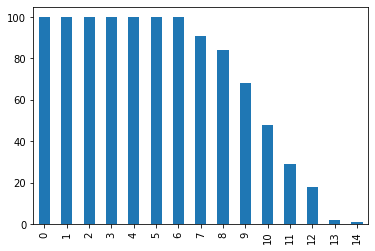

In [12]:
model_sel_count = model_sel.drop(['Success Rate', 'Runtime(Seconds)', 'Top Models SR'], axis =1).count()
model_sel_count.plot.bar()

In [15]:
model_sel['Top Models SR'].describe()

count    100.000000
mean       0.669925
std        0.024951
min        0.607500
25%        0.652500
50%        0.672500
75%        0.685625
max        0.730000
Name: Top Models SR, dtype: float64

**Conclusions/Recommendations**

During exploratory runs, the model success rate seems a bit low. Additional runs are pending, but here are some recommendations for improvement:

1. Explore the possibility of weighting the data to account for the survey design. This may improve the model success rate if there are indeed features that can distinguish between the food consumption habits of the participants.
2. Address the issue with meals that contain both seafood and some other type of meat. Should this be considered a seafood meal?
3. Can we exclude meals that are consumed outside the home? Is there a possibility that consumption patterns are similar for seafood vs non in a restaurant environment? Are participants who choose seafood as a health choice more likely to eat at home, providing better separation for this model fit?
4. A tree based model can also be used for this type of problem. Tree based models provide some explanatory power through the tree branches, though they can be a bit a more complex to interpret and do not provide stastical odd ratios.